In [1]:
from mpl_toolkits.basemap import Basemap
from nltk.tokenize import word_tokenize
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from spacy.matcher import Matcher
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats
import seaborn as sns
import networkx as nx
import pandas as pd
import numpy as np
import pickle
import heapq
import spacy
import nltk
#nltk.download('stopwords')
nlp = spacy.load("es_core_news_md")

## Introducción

El presente trabajo tiene como objetivo analizar la evolución de las menciones a países en noticias de prensa chilena que abordan el tema de la inmigración. Para ello, se ha recopilado un conjunto de datos que abarca el período comprendido entre 2015 y 2023. A partir de estas noticias, se ha construido un grafo donde los nodos representan los países y las conexiones entre ellos reflejan su co-aparición en las noticias, ponderadas por la frecuencia de estas menciones. El propósito es visualizar y comprender las relaciones entre los países y cómo estas han variado a lo largo del tiempo.

## Hipótesis:
Se plantea la hipótesis de que existirán subgrafos dentro del grafo principal que reflejen agrupamientos geográficos de los países mencionados en las noticias. Además, se espera que estos subgrafos evolucionen con el tiempo, mostrando cambios en las conexiones entre los países y la incorporación o exclusión de algunos de ellos.

## Metodología:
Se inició la recolección de datos mediante la búsqueda de noticias de prensa chilena que contengan la palabra clave "inmigración". A partir de estas noticias, se extrajo la información sobre los países mencionados utilizando una lista de países, gentilicios y gentilicios en plural. Con estos datos, se construyó un grafo donde los países representan los nodos y las conexiones se establecen en función de su co-aparición en las noticias.

In [2]:
dataset = pd.read_csv("inmigración_chile_2015-01-01_2023-12-31.csv")
dataset.drop('Unnamed: 0', axis=1, inplace=True)
dataset.head(5)

,id_news,country,media_outlet,url,title,text,date,search
0,14206853.0,chile,emol,https://www.emol.com/noticias/Nacional/2016/11...,"Marco Enríquez-Ominami critica a Piñera: ""La i...","SANTIAGO.- ""La inmigración no se puede demoniz...",2016-11-30,inmigración
1,49593944.0,chile,elmostrador,https://www.elmostrador.cl/noticias/pais/2022/...,"61% de las personas encuestadas dice estar ""co...",Durante este jueves el Centro de Estudios Públ...,2022-06-09,inmigración
2,49082552.0,chile,latercera,https://www.latercera.com/politica/noticia/enc...,Encuesta CEP: un 61% de los encuestados asegur...,Este jueves se dio a conocer una nueva versión...,2022-06-09,inmigración
3,49247349.0,chile,cnnchile,https://www.cnnchile.com/mundo/donald-trump-nu...,Trump dice que su plan de inmigración creará u...,"Donald Trump, presidente de Estados Unidos, pr...",2019-05-16,inmigración
4,49581089.0,chile,eldinamo,https://www.eldinamo.cl/mundo/2016/11/11/trump...,Trump recalca que primera medida como presiden...,"Tras ganar las elecciones presidenciales, Dona...",2016-11-11,inmigración


In [3]:
print("Filas y columnas del dataset: "+str(dataset.shape))
print()
print(dataset.info())
print()
print("Cantidad de null en cada columnas: " + str(dataset.isnull().sum()))
print()
print("Cantidad de valores duplicados: " + str(dataset.duplicated().sum()))
dataset['date'] = pd.to_datetime(dataset['date'])

Filas y columnas del dataset: (3447, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_news       3447 non-null   float64
 1   country       3447 non-null   object 
 2   media_outlet  3447 non-null   object 
 3   url           3447 non-null   object 
 4   title         3447 non-null   object 
 5   text          3447 non-null   object 
 6   date          3447 non-null   object 
 7   search        3447 non-null   object 
dtypes: float64(1), object(7)
memory usage: 215.6+ KB
None

Cantidad de null en cada columnas: id_news         0
country         0
media_outlet    0
url             0
title           0
text            0
date            0
search          0
dtype: int64

Cantidad de valores duplicados: 0


In [4]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [5]:
df_paises = pd.read_csv('paises.csv')
df_gentilicios = pd.read_csv('Gentilicios.csv')
df_gentilicios_plural = pd.read_csv('Gentilicios_plural.csv')

gentilicios = df_gentilicios['Gentilicios'].tolist()
gentilicios_plural = df_gentilicios_plural['Gentilicios_plural'].tolist()
paises= df_paises['Pais'].tolist()

with open('gentilicios_dic.pkl', 'rb') as file:
    gentilicios_dic = pickle.load(file)
gentilicios_dicc = {valor: clave for clave, valor in gentilicios_dic.items()}

with open('gentilicios_dic_plural.pkl', 'rb') as file:
    gentilicios_dic_plural = pickle.load(file)
gentilicios_dicc_plural = {valor: clave for clave, valor in gentilicios_dic_plural.items()}

In [6]:
def buscar_palabras(dataset, palabras):
    palabras_encontradas = []
    for fila in dataset['text']:
        palabras_fila = []
        for palabra in palabras:
            if palabra in fila:
                palabras_fila.append(palabra)
        palabras_encontradas.append(palabras_fila)
    return palabras_encontradas


paises_data = buscar_palabras(dataset, paises)
gentilicios_data = buscar_palabras(dataset, gentilicios)
gentilicios_plural_data = buscar_palabras(dataset,gentilicios_plural)

In [7]:
gentilicios = [[gentilicios_dicc.get(valor, valor) for valor in sublista] for sublista in gentilicios_data]
gentilicios_plural = [[gentilicios_dicc_plural.get(valor, valor) for valor in sublista] for sublista in gentilicios_plural_data]

In [8]:
paises_unicos = []
for elemento1, elemento2, elemento3 in zip(paises_data,gentilicios,gentilicios_plural):
    fila = [elemento1, elemento2, elemento3]
    fila_plana=sum(fila, [])
    paises_unicos.append((sorted(set(fila_plana))))


In [13]:
dataset['pais'] = paises_unicos
dataset = dataset[dataset['pais'].apply(lambda x: len(x) > 1)]
df_network = dataset[['id_news','pais']]

In [9]:
paises_location = np.unique([item for sublist in paises_unicos for item in sublist])
geolocator = Nominatim(user_agent="my_app", timeout=10)
coordenadas = {}
for pais in paises_location:
    location = geolocator.geocode(pais)
    coordenadas[pais] = (location.latitude, location.longitude)
  

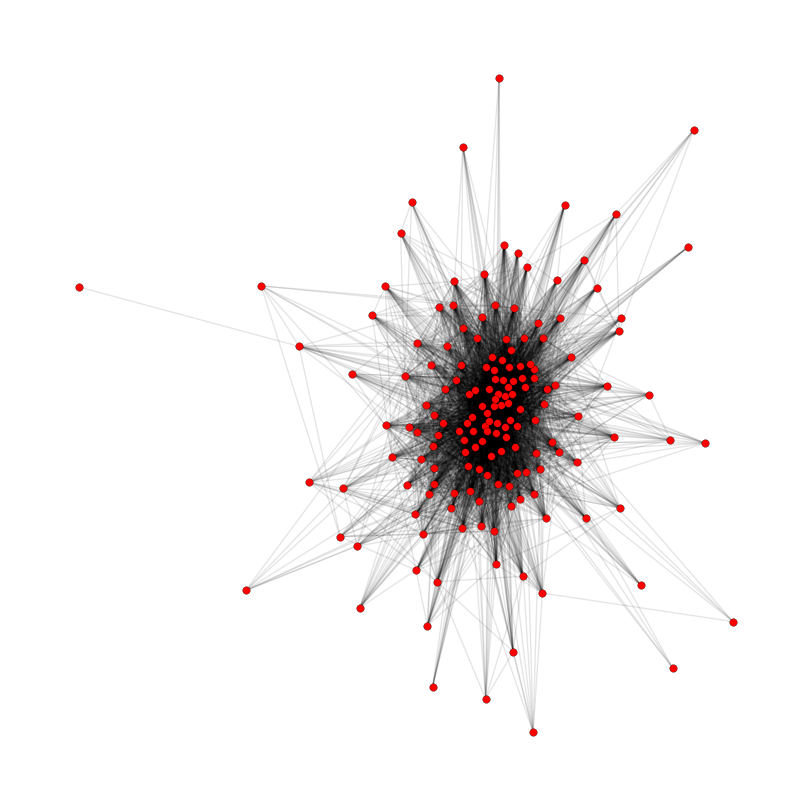

In [14]:
G = nx.Graph()

for _, row in df_network.iterrows():
    paises = row['pais']
    for i in range(len(paises)):
        for j in range(i + 1, len(paises)):
            peso = G.get_edge_data(paises[i], paises[j], default={'weight': 0})['weight'] + 1
            G.add_edge(paises[i], paises[j], weight=peso)
            
            
labels = nx.get_edge_attributes(G,'weight')    
weights = list(labels.values())
max_weight = max(weights)    
normalized_weights = [(weight / max_weight)+1 for weight in weights]

fig, axs = plt.subplots(figsize=(8,8), facecolor='w', nrows=1, ncols=1, constrained_layout=True)
pos = nx.layout.circular_layout(G)
pos = nx.spring_layout(G, pos=pos, k=0.7, iterations=100, seed=0)
sc = nx.draw_networkx_nodes(G, pos, linewidths=0.2, node_color='red', edgecolors='black', ax=axs, node_size=30)
nx.draw_networkx_edges(G, pos, width=normalized_weights, ax=axs,alpha=0.1)
axs.axis('off')
plt.show()

Una vez construido el grafo principal, se identificaron los pares de países que se encuentran a menos de 5000 kilómetros de distancia y que tenían una conexión con un peso mayor a 5. Estos pares formaron un nuevo grafo, el cual se visualizó en un mapa del planeta. Al aplicar el algoritmo de Louvain para identificar comunidades en este nuevo grafo, se observaron subgrafos que reflejan agrupamientos geográficos, como América del Norte y Centroamérica, América del Sur, Europa, África, Asia y Oceanía.

In [15]:
G_map = nx.Graph()
pais_location = []
weights = nx.get_edge_attributes(G, "weight")

top_20_edges = heapq.nlargest(1000, weights.items(), key=lambda x: x[1])
for edge, weight in top_20_edges:
    pais1, pais2 = edge
    distancia = geodesic((coordenadas[pais2][0], coordenadas[pais2][1]), (coordenadas[pais1][0], coordenadas[pais1][1])).kilometers
    print(f"{pais1} - {pais2}, {weight}, {distancia}")
    if distancia < 5000 and weight>5 :
        G_map.add_edge(pais1, pais2, weight=weight)
        pais_location.append([pais1,pais2])
    if weight<5:
        break

Estados Unidos - México, 720, 1794.0790951556621
Estados Unidos - Chile, 261, 8472.51531963119
Venezuela - Chile, 255, 4435.014371087848
Estados Unidos - Venezuela, 171, 4904.221338865609
Chile - Perú, 171, 2782.8103558309076
Estados Unidos - Guatemala, 167, 2855.9883727729975
Estados Unidos - España, 159, 7765.881473728896
México - Guatemala, 155, 1513.6296697663
Estados Unidos - China, 153, 11323.518191320525
Chile - Colombia, 152, 3972.31813291895
Estados Unidos - Honduras, 147, 3056.925092275667
Chile - Argentina, 142, 691.178340786808
Estados Unidos - El Salvador, 140, 3092.5984007460365
Chile - Haití, 140, 5633.643825523363
Chile - Bolivia, 137, 1749.6009033849014
México - Honduras, 135, 1911.6969751292131
Estados Unidos - Canadá, 127, 2423.6096509121558
México - El Salvador, 126, 1757.9635190217477
Estados Unidos - Cuba, 123, 2622.0047411961978
Venezuela - Colombia, 122, 867.3489238716869
Estados Unidos - Francia, 120, 7734.861746186841
México - Chile, 119, 6949.070087620296
Est

Canadá - Bélgica, 7, 6253.052986241051
Canadá - Vietnam, 7, 10893.993780134811
Canadá - Nueva Zelanda, 7, 13407.102174923506
China - Costa Rica, 7, 14903.773298739698
China - Hungría, 7, 6946.7235099990585
China - Mauricio, 7, 7907.326076985852
China - Arabia Saudita, 7, 6018.383508433671
China - Portugal, 7, 9272.883689140848
China - Uruguay, 7, 18258.71466074153
México - Sudán, 7, 13260.051829633121
México - Bélgica, 7, 9105.894929339804
Alemania - Eritrea, 7, 4612.55408196024
Alemania - Corea del Sur, 7, 8521.287601513857
Alemania - Marruecos, 7, 2659.6440172516786
Alemania - Haití, 7, 7877.754122227438
Alemania - Líbano, 7, 2809.499705603699
Francia - Egipto, 7, 3304.1975612645765
Francia - Argelia, 7, 2067.0022288449536
Francia - Pakistán, 7, 6109.46811775152
Francia - Singapur, 7, 10810.20789919006
Francia - Croacia, 7, 1074.3259384398502
Francia - Bulgaria, 7, 1917.3567460766658
Francia - Eslovaquia, 7, 1337.1474989840494
Francia - Uruguay, 7, 10543.405911327709
Chile - Dinamarc

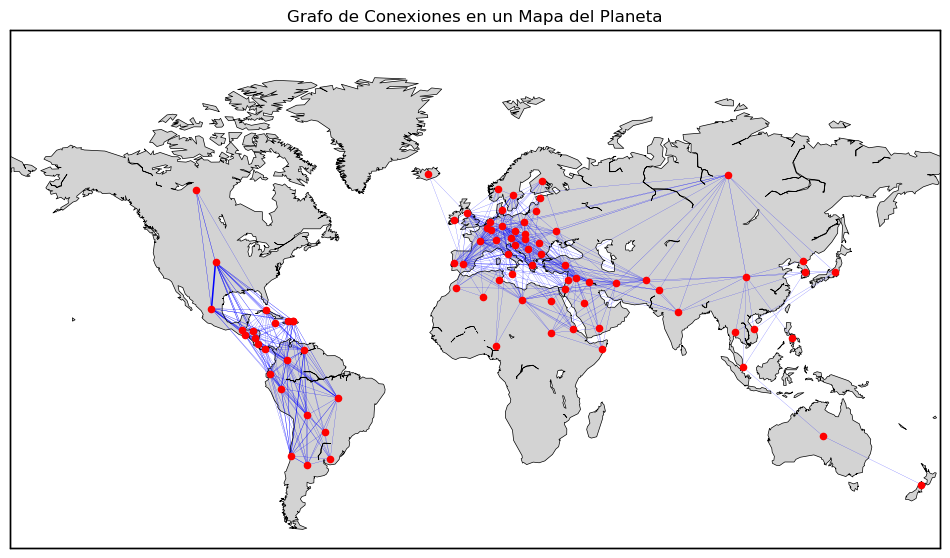

In [27]:
fig = plt.figure(figsize=(12, 8))
m = Basemap(projection='mill', llcrnrlat=-60, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='lightgray', lake_color='white')
m.drawmapboundary(fill_color='white')

labels = nx.get_edge_attributes(G_map,'weight') 

pos = {}
for country in coordenadas:
    x, y = m(coordenadas[country][1], coordenadas[country][0])
    pos[country] = (x, y)
  
    
weights = list(labels.values())
max_weight = max(weights)    
normalized_weights = [(weight / max_weight)+0.1 for weight in weights]

nx.draw_networkx_edges(G_map, pos, width=normalized_weights, alpha=1, edge_color='b', arrows=False)
nx.draw_networkx_nodes(G_map, pos, node_color='red',node_size=20)

plt.title("Grafo de Conexiones en un Mapa del Planeta")
plt.show()

In [19]:
comunidades = nx.community.louvain_communities(G_map, seed=123)
grupos = {}

for i, comunidad in enumerate(comunidades):
    for nodo in comunidad:
        grupos[nodo] = i
        
subgrafos = []
for comunidad in comunidades:
    subgrafo = G_map.subgraph(comunidad)
    subgrafos.append(subgrafo)

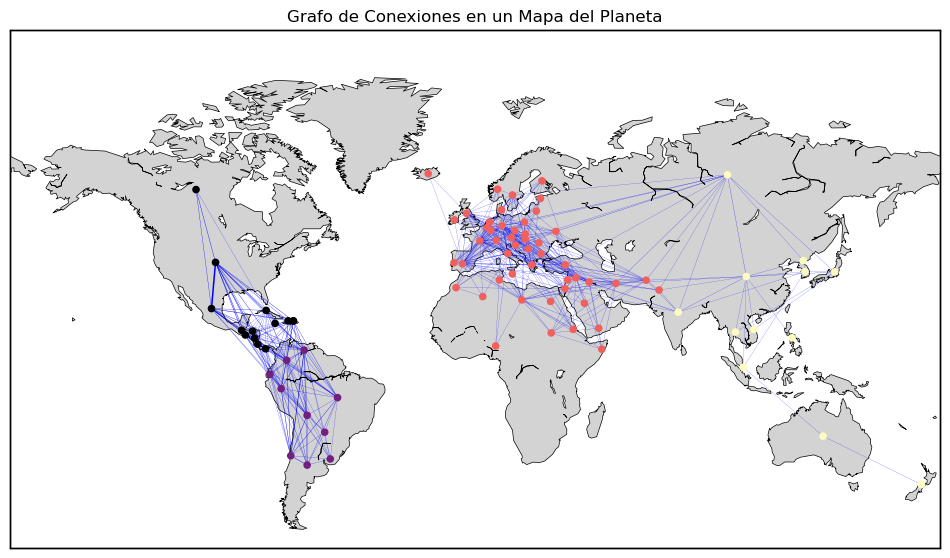

In [22]:
fig = plt.figure(figsize=(12, 8))

delta = 20
#m = Basemap(projection='mill', llcrnrlat=lat_prom-delta, urcrnrlat=lat_prom+delta,
 #           llcrnrlon=lon_prom-delta, urcrnrlon=lon_prom+delta, resolution='c')

m = Basemap(projection='mill', llcrnrlat=-60, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='lightgray', lake_color='white')
m.drawmapboundary(fill_color='white')

labels = nx.get_edge_attributes(G_map,'weight') 

pos = {}
for country in coordenadas:
    x, y = m(coordenadas[country][1], coordenadas[country][0])
    pos[country] = (x, y)
    #m.plot(x, y, 'ro', markersize=5)
    
weights = list(labels.values())
max_weight = max(weights)    
normalized_weights = [(weight / max_weight)+0.1 for weight in weights]

nx.draw_networkx_edges(G_map, pos, width=normalized_weights, alpha=1, edge_color='b', arrows=False)
nx.draw_networkx_nodes(G_map, pos, node_color=[grupos[nodo] for nodo in G_map.nodes()], cmap='magma',node_size=20)
#nx.draw_networkx_labels(G_map, pos, font_size=8, font_weight='bold')

plt.title("Grafo de Conexiones en un Mapa del Planeta")
plt.show()

In [32]:
colores = ['#FF0000', '#00FF00', '#0000FF', '#FF00FF', '#00FFFF', '#FFFF00', '#FFA500', '#800080',
           '#008000', '#800000', '#FF1493', '#00CED1', '#FF4500', '#7B68EE', '#FFC0CB', '#8A2BE2',
           '#008080', '#FFD700', '#DC143C', '#6A5ACD', '#2E8B57', '#B22222', '#FF69B4', '#4169E1',
           '#FF8C00', '#9932CC', '#8B0000', '#00FA9A', '#ADFF2F', '#4B0082', '#FFB6C1', '#6B8E23',
           '#BA55D3', '#6495ED', '#FF7F50', '#008B8B', '#8B008B', '#FF6347', '#00FF7F', '#DA70D6',
           '#ADFF2F', '#7FFF00', '#FF4500', '#FF8C00', '#FFD700', '#ADFF2F', '#008000', '#006400',
           '#4B0082', '#800080', '#8B008B', '#000080', '#00008B', '#1E90FF', '#00BFFF', '#008080',
           '#00FF7F', '#32CD32', '#9ACD32', '#FF0000', '#FF69B4']



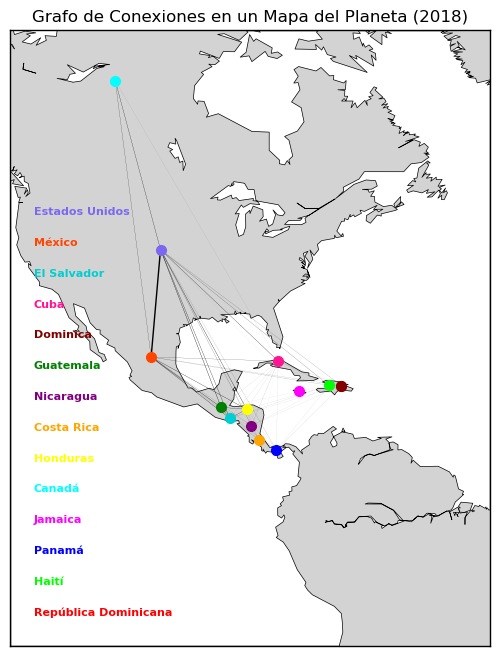

In [53]:
fig = plt.figure(figsize=(12, 8))
import matplotlib.colors as mcolors

graph = 0

lat_prom = np.mean([coordenadas[country][0] for country in comunidades[graph]])
lon_prom = np.mean([coordenadas[country][1] for country in comunidades[graph]])

delta_lat = 45
delta_lon = 40
m = Basemap(projection='mill', llcrnrlat=lat_prom-delta_lat, urcrnrlat=lat_prom+delta_lat,
            llcrnrlon=lon_prom-delta_lon, urcrnrlon=lon_prom+delta_lon, resolution='c')

m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='lightgray', lake_color='white')
m.drawmapboundary(fill_color='white')

labels = nx.get_edge_attributes(subgrafos[graph], 'weight')



pos = {}
for country ,color in zip(comunidades[graph], colores):
    x, y = m(coordenadas[country][1], coordenadas[country][0])
    pos[country] = (x, y)
    m.plot(x, y, 'o', markersize=7, color=color)  

weights = list(labels.values())
max_weight = max(weights)
normalized_weights = [weight / max_weight for weight in weights]

nx.draw_networkx_edges(subgrafos[graph], pos, width=normalized_weights, alpha=1, edge_color='black', arrows=False)

corner_x = 0.05
corner_y = 0.05
offset_x = 0.0
offset_y = 0.05

# Agregar etiquetas de los países en la esquina
for country, color in zip(comunidades[graph], colores):
    x, y = m(coordenadas[country][1], coordenadas[country][0])
    plt.annotate(country, xy=(x, y), xytext=(corner_x, corner_y),
                 textcoords='axes fraction', color=color, fontsize=8, fontweight='bold')
    corner_y += offset_y
    corner_x += offset_x

plt.title("Grafo de Conexiones en un Mapa del Planeta (2018)")
plt.show()



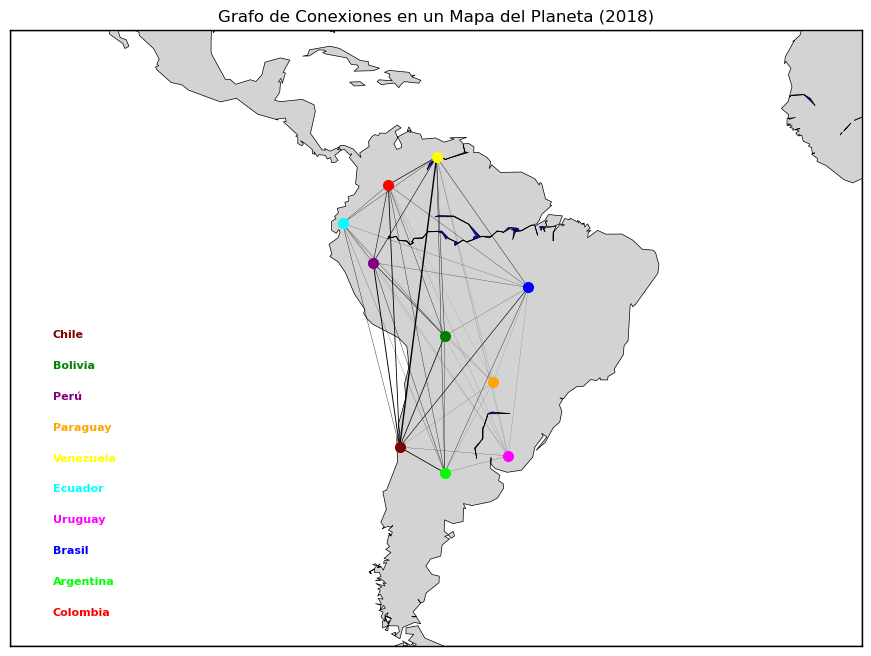

In [50]:
fig = plt.figure(figsize=(12, 8))
import matplotlib.colors as mcolors

graph = 1

lat_prom = np.mean([coordenadas[country][0] for country in comunidades[graph]])
lon_prom = np.mean([coordenadas[country][1] for country in comunidades[graph]])

delta_lat = 40
delta_lon = 60
m = Basemap(projection='mill', llcrnrlat=lat_prom-delta_lat, urcrnrlat=lat_prom+delta_lat,
            llcrnrlon=lon_prom-delta_lon, urcrnrlon=lon_prom+delta_lon, resolution='c')

m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='lightgray', lake_color='blue')
m.drawmapboundary(fill_color='white')

labels = nx.get_edge_attributes(subgrafos[graph], 'weight')


pos = {}
for country ,color in zip(comunidades[graph], colores):
    x, y = m(coordenadas[country][1], coordenadas[country][0])
    pos[country] = (x, y)
    m.plot(x, y, 'o', markersize=7, color=color)  

weights = list(labels.values())
max_weight = max(weights)
normalized_weights = [weight / max_weight for weight in weights]

nx.draw_networkx_edges(subgrafos[graph], pos, width=normalized_weights, alpha=1, edge_color='black', arrows=False)

corner_x = 0.05
corner_y = 0.05
offset_x = 0.0
offset_y = 0.05

# Agregar etiquetas de los países en la esquina
for country, color in zip(comunidades[graph], colores):
    x, y = m(coordenadas[country][1], coordenadas[country][0])
    plt.annotate(country, xy=(x, y), xytext=(corner_x, corner_y),
                 textcoords='axes fraction', color=color, fontsize=8, fontweight='bold')
    corner_y += offset_y
    corner_x += offset_x

plt.title("Grafo de Conexiones en un Mapa del Planeta (2018)")
plt.show()

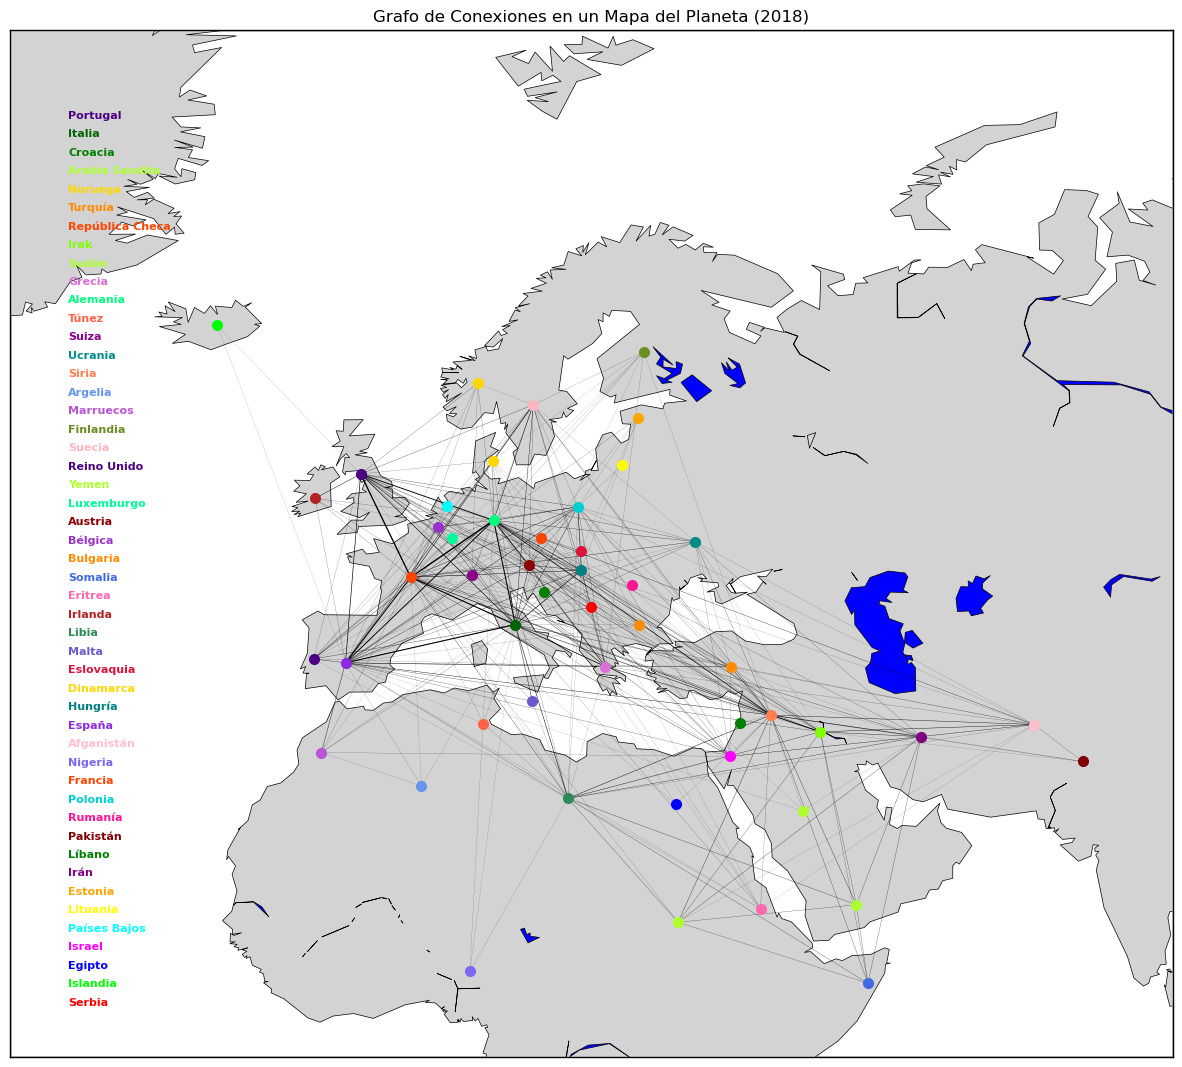

In [49]:
fig = plt.figure(figsize=(15, 15))
import matplotlib.colors as mcolors

graph = 2

lat_prom = np.mean([coordenadas[country][0] for country in comunidades[graph]])
lon_prom = np.mean([coordenadas[country][1] for country in comunidades[graph]])

delta_lat = 40
delta_lon = 60
m = Basemap(projection='mill', llcrnrlat=lat_prom-delta_lat, urcrnrlat=lat_prom+delta_lat,
            llcrnrlon=lon_prom-delta_lon, urcrnrlon=lon_prom+delta_lon, resolution='c')

m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='lightgray', lake_color='blue')
m.drawmapboundary(fill_color='white')

labels = nx.get_edge_attributes(subgrafos[graph], 'weight')


pos = {}
for country ,color in zip(comunidades[graph], colores):
    x, y = m(coordenadas[country][1], coordenadas[country][0])
    pos[country] = (x, y)
    m.plot(x, y, 'o', markersize=7, color=color)  

weights = list(labels.values())
max_weight = max(weights)
normalized_weights = [weight / max_weight for weight in weights]

nx.draw_networkx_edges(subgrafos[graph], pos, width=normalized_weights, alpha=1, edge_color='black', arrows=False)

corner_x = 0.05
corner_y = 0.05
offset_x = 0.0
offset_y = 0.018

# Agregar etiquetas de los países en la esquina
for country, color in zip(comunidades[graph], colores):
    x, y = m(coordenadas[country][1], coordenadas[country][0])
    plt.annotate(country, xy=(x, y), xytext=(corner_x, corner_y),
                 textcoords='axes fraction', color=color, fontsize=8, fontweight='bold')
    corner_y += offset_y
    corner_x += offset_x

plt.title("Grafo de Conexiones en un Mapa del Planeta (2018)")
plt.show()

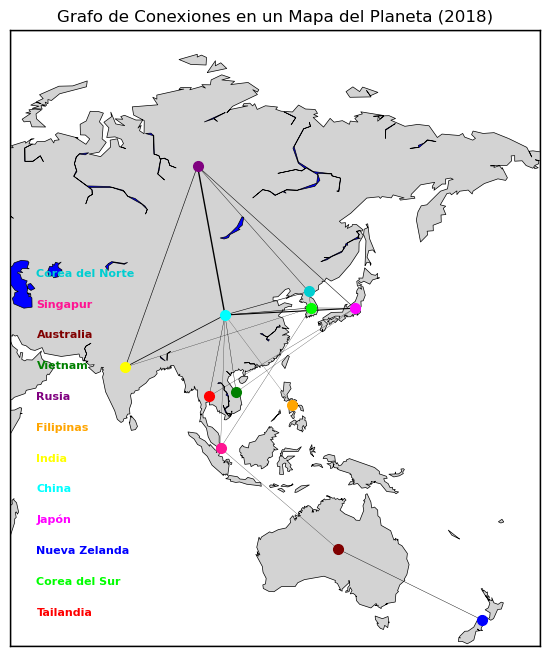

In [58]:
fig = plt.figure(figsize=(12, 8))
import matplotlib.colors as mcolors

graph = 3

lat_prom = np.mean([coordenadas[country][0] for country in comunidades[graph]])
lon_prom = np.mean([coordenadas[country][1] for country in comunidades[graph]])

delta_lat = 65
delta_lon = 70
m = Basemap(projection='mill', llcrnrlat=lat_prom-delta_lat, urcrnrlat=lat_prom+delta_lat,
            llcrnrlon=lon_prom-delta_lon, urcrnrlon=lon_prom+delta_lon, resolution='c')

m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='lightgray', lake_color='blue')
m.drawmapboundary(fill_color='white')

labels = nx.get_edge_attributes(subgrafos[graph], 'weight')


pos = {}
for country ,color in zip(comunidades[graph], colores):
    x, y = m(coordenadas[country][1], coordenadas[country][0])
    pos[country] = (x, y)
    m.plot(x, y, 'o', markersize=7, color=color)  

weights = list(labels.values())
max_weight = max(weights)
normalized_weights = [weight / max_weight for weight in weights]

nx.draw_networkx_edges(subgrafos[graph], pos, width=normalized_weights, alpha=1, edge_color='black', arrows=False)

corner_x = 0.05
corner_y = 0.05
offset_x = 0.0
offset_y = 0.05

# Agregar etiquetas de los países en la esquina
for country, color in zip(comunidades[graph], colores):
    x, y = m(coordenadas[country][1], coordenadas[country][0])
    plt.annotate(country, xy=(x, y), xytext=(corner_x, corner_y),
                 textcoords='axes fraction', color=color, fontsize=8, fontweight='bold')
    corner_y += offset_y
    corner_x += offset_x

plt.title("Grafo de Conexiones en un Mapa del Planeta (2018)")
plt.show()

A continuación, se estudiaron los subgrafos en función del tiempo, específicamente entre 2017 y 2019. Se analizó cómo evolucionaron estas comunidades, identificando los países que se agregaron y los que se eliminaron de cada subgrafo.

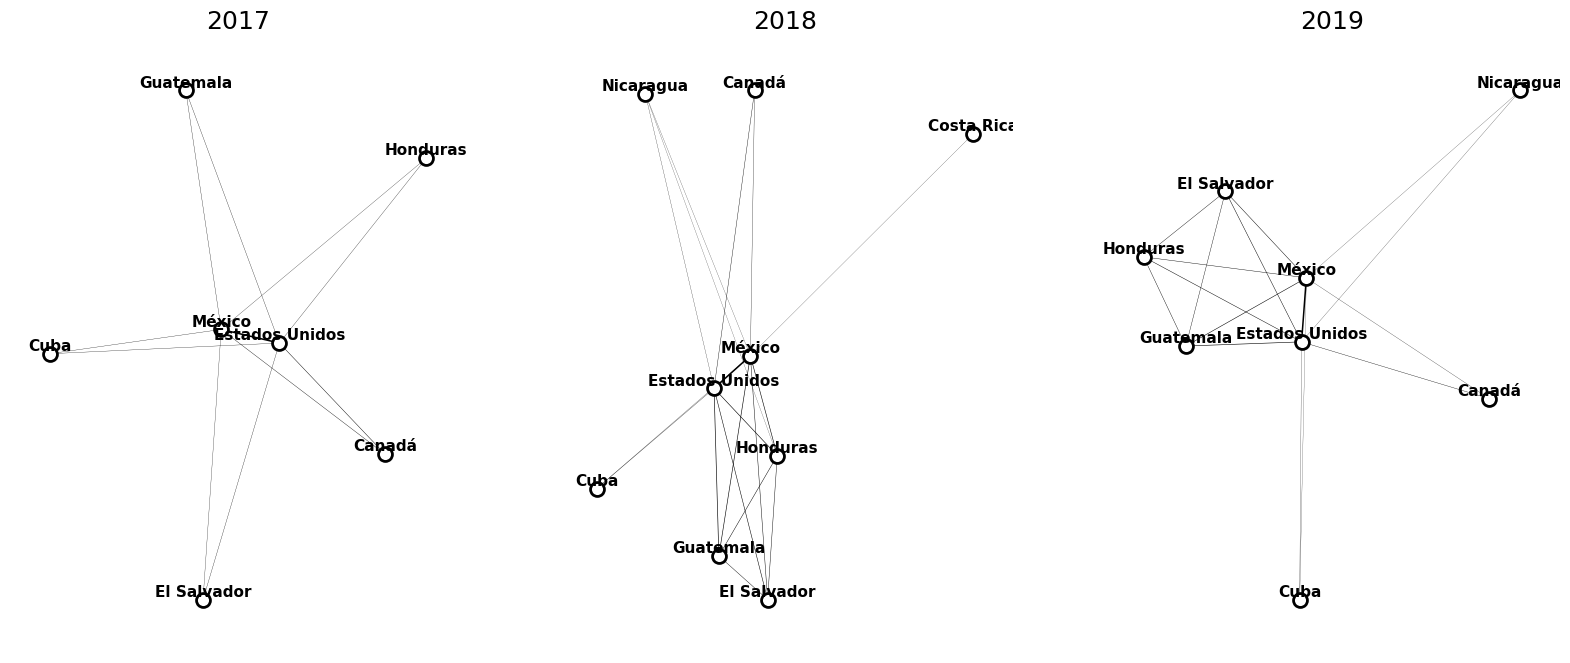

In [68]:
fig, axs = plt.subplots(figsize=(20,8), facecolor="w", nrows=1, ncols=3)
k = 0
for year in range(2017,2020):
    
    df_date = dataset[dataset['date'].dt.year == year][['id_news','pais']]
    
    G = nx.Graph()

    for _, row in df_date.iterrows():
        paises = row['pais']
        for i in range(len(paises)):
            for j in range(i + 1, len(paises)):
                peso = G.get_edge_data(paises[i], paises[j], default={'weight': 0})['weight'] + 1
                G.add_edge(paises[i], paises[j], weight=peso)
                
    G_map = nx.Graph()
    
    weights = nx.get_edge_attributes(G, "weight")

    edges = heapq.nlargest(1000, weights.items(), key=lambda x: x[1])
    for edge, weight in edges:
        pais1, pais2 = edge
        distancia = geodesic((coordenadas[pais2][0], coordenadas[pais2][1]), (coordenadas[pais1][0], coordenadas[pais1][1])).kilometers
    
        if distancia < 5000 and weight>5 :
            G_map.add_edge(pais1, pais2, weight=weight)
            
        if weight<5:
            break
            
    comunidades = nx.community.louvain_communities(G_map, seed=123)
    grupos = {}

    for i, comunidad in enumerate(comunidades):
        for nodo in comunidad:
            grupos[nodo] = i
        
    subgrafos = []
    for comunidad in comunidades:
        subgrafo = G_map.subgraph(comunidad)
        subgrafos.append(subgrafo)
        
    graph = 0
    
    pos = nx.layout.circular_layout(subgrafos[graph])
    pos = nx.spring_layout(subgrafos[graph], pos=pos, k=0.7, iterations=200, seed=0)
    
    
    nx.draw_networkx_nodes(subgrafos[graph], pos, node_color='white', linewidths=2, 
      edgecolors='k', ax=axs[k], node_size=100)
    labels = nx.get_edge_attributes(subgrafos[graph], 'weight')
    weights = list(labels.values())
    normalized_weights = [(weight /  max(weights))+0.1 for weight in weights]
    nx.draw_networkx_edges(subgrafos[graph], pos, width=normalized_weights, ax=axs[k])
  
    nx.draw_networkx_labels(subgrafos[graph], pos, font_size=11, font_weight='bold',verticalalignment='bottom', ax=axs[k])
    axs[k].spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    axs[k].set_title("${%i}$" % (year), fontsize=18)
    k = k+1

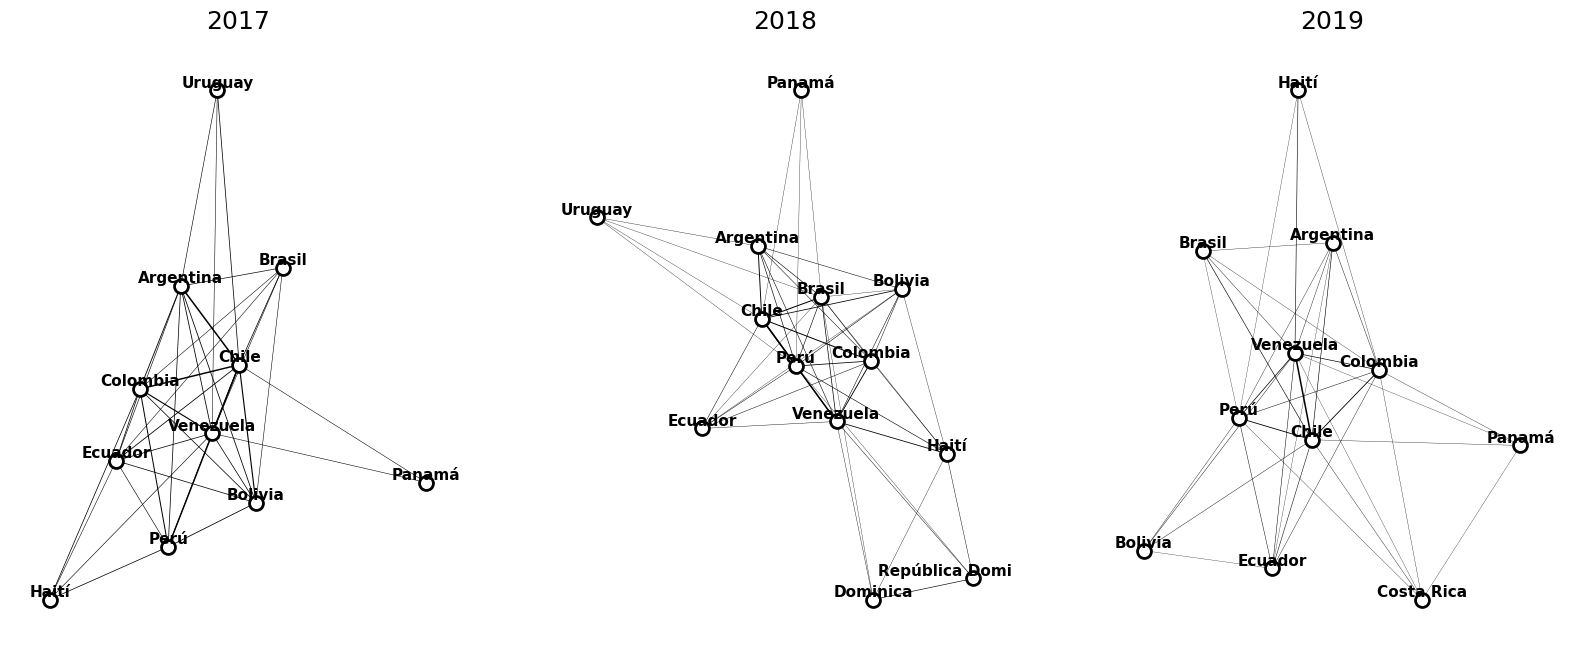

In [70]:
fig, axs = plt.subplots(figsize=(20,8), facecolor="w", nrows=1, ncols=3)
k = 0
for year in range(2017,2020):
    
    df_date = dataset[dataset['date'].dt.year == year][['id_news','pais']]
    
    G = nx.Graph()

    for _, row in df_date.iterrows():
        paises = row['pais']
        for i in range(len(paises)):
            for j in range(i + 1, len(paises)):
                peso = G.get_edge_data(paises[i], paises[j], default={'weight': 0})['weight'] + 1
                G.add_edge(paises[i], paises[j], weight=peso)
                
    G_map = nx.Graph()
    
    weights = nx.get_edge_attributes(G, "weight")

    edges = heapq.nlargest(1000, weights.items(), key=lambda x: x[1])
    for edge, weight in edges:
        pais1, pais2 = edge
        distancia = geodesic((coordenadas[pais2][0], coordenadas[pais2][1]), (coordenadas[pais1][0], coordenadas[pais1][1])).kilometers
    
        if distancia < 5000 and weight>5 :
            G_map.add_edge(pais1, pais2, weight=weight)
            
        if weight<5:
            break
            
    comunidades = nx.community.louvain_communities(G_map, seed=123)
    grupos = {}

    for i, comunidad in enumerate(comunidades):
        for nodo in comunidad:
            grupos[nodo] = i
        
    subgrafos = []
    for comunidad in comunidades:
        subgrafo = G_map.subgraph(comunidad)
        subgrafos.append(subgrafo)
        
    graph = 1
    if year == 2018:
        graph = 2
    
    pos = nx.layout.circular_layout(subgrafos[graph])
    pos = nx.spring_layout(subgrafos[graph], pos=pos, k=0.7, iterations=200, seed=0)
    
    
    nx.draw_networkx_nodes(subgrafos[graph], pos, node_color='white', linewidths=2, 
      edgecolors='k', ax=axs[k], node_size=100)
    labels = nx.get_edge_attributes(subgrafos[graph], 'weight')
    weights = list(labels.values())
    normalized_weights = [(weight /  max(weights))+0.1 for weight in weights]
    nx.draw_networkx_edges(subgrafos[graph], pos, width=normalized_weights, ax=axs[k])
  
    nx.draw_networkx_labels(subgrafos[graph], pos, font_size=11, font_weight='bold',verticalalignment='bottom', ax=axs[k])
    axs[k].spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    axs[k].set_title("${%i}$" % (year), fontsize=18)
    k = k+1

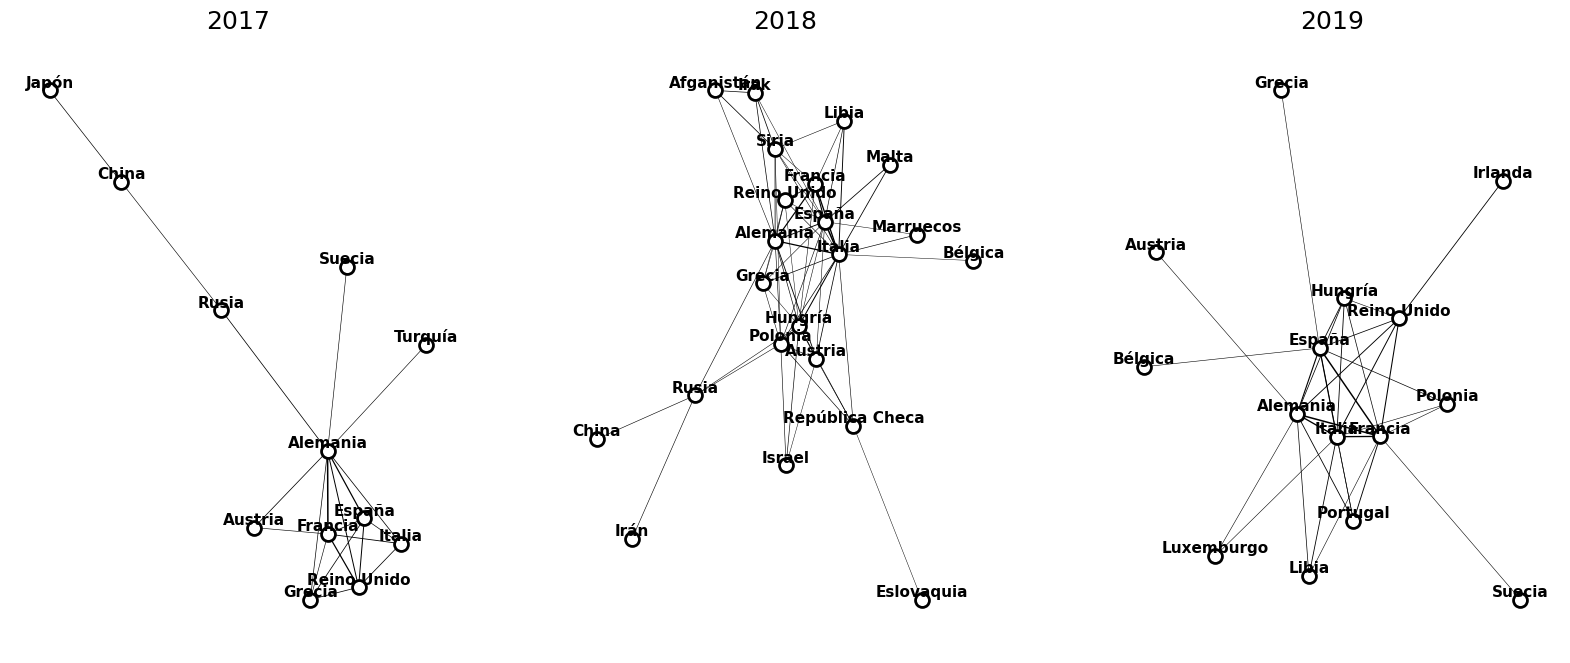

In [80]:
fig, axs = plt.subplots(figsize=(20,8), facecolor="w", nrows=1, ncols=3)
k = 0
for year in range(2017,2020):
    
    df_date = dataset[dataset['date'].dt.year == year][['id_news','pais']]
    
    G = nx.Graph()

    for _, row in df_date.iterrows():
        paises = row['pais']
        for i in range(len(paises)):
            for j in range(i + 1, len(paises)):
                peso = G.get_edge_data(paises[i], paises[j], default={'weight': 0})['weight'] + 1
                G.add_edge(paises[i], paises[j], weight=peso)
                
    G_map = nx.Graph()
    
    weights = nx.get_edge_attributes(G, "weight")

    edges = heapq.nlargest(1000, weights.items(), key=lambda x: x[1])
    for edge, weight in edges:
        pais1, pais2 = edge
        distancia = geodesic((coordenadas[pais2][0], coordenadas[pais2][1]), (coordenadas[pais1][0], coordenadas[pais1][1])).kilometers
    
        if distancia < 5000 and weight>5 :
            G_map.add_edge(pais1, pais2, weight=weight)
            
        if weight<5:
            break
            
    comunidades = nx.community.louvain_communities(G_map, seed=123)
    grupos = {}

    for i, comunidad in enumerate(comunidades):
        for nodo in comunidad:
            grupos[nodo] = i
        
    subgrafos = []
    for comunidad in comunidades:
        subgrafo = G_map.subgraph(comunidad)
        subgrafos.append(subgrafo)
        
    graph = 3
    if year == 2018:
        graph = 1
    if year == 2019:
        graph = 2
    
    pos = nx.layout.circular_layout(subgrafos[graph])
    pos = nx.spring_layout(subgrafos[graph], pos=pos, k=0.7, iterations=300, seed=0)
    
    
    nx.draw_networkx_nodes(subgrafos[graph], pos, node_color='white', linewidths=2, 
      edgecolors='k', ax=axs[k], node_size=100)
    labels = nx.get_edge_attributes(subgrafos[graph], 'weight')
    weights = list(labels.values())
    normalized_weights = [(weight /  max(weights))+0.1 for weight in weights]
    nx.draw_networkx_edges(subgrafos[graph], pos, width=normalized_weights, ax=axs[k])
  
    nx.draw_networkx_labels(subgrafos[graph], pos, font_size=11, font_weight='bold',verticalalignment='bottom', ax=axs[k])
    axs[k].spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    axs[k].set_title("${%i}$" % (year), fontsize=18)
    k = k+1

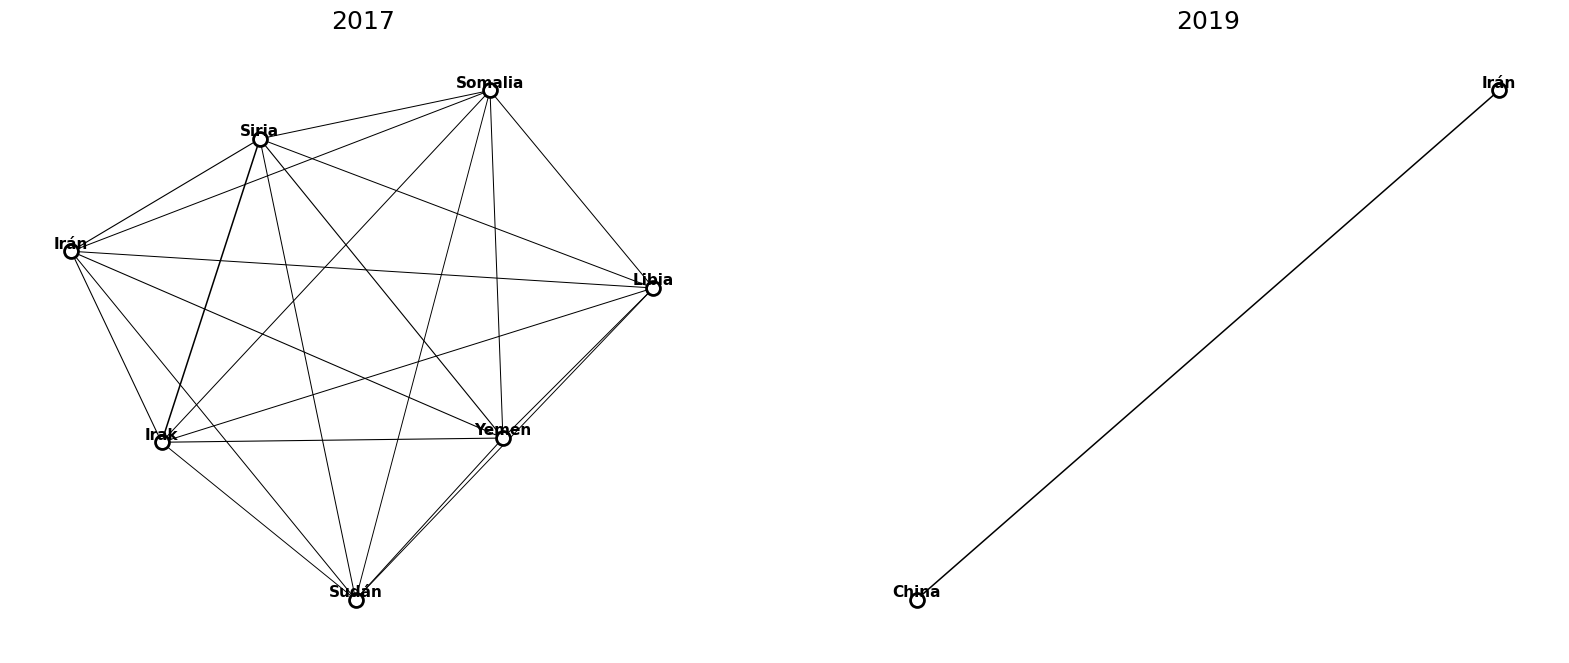

In [84]:
fig, axs = plt.subplots(figsize=(20,8), facecolor="w", nrows=1, ncols=2)
k = 0
for year in [2017,2019]:
    
    df_date = dataset[dataset['date'].dt.year == year][['id_news','pais']]
    
    G = nx.Graph()

    for _, row in df_date.iterrows():
        paises = row['pais']
        for i in range(len(paises)):
            for j in range(i + 1, len(paises)):
                peso = G.get_edge_data(paises[i], paises[j], default={'weight': 0})['weight'] + 1
                G.add_edge(paises[i], paises[j], weight=peso)
                
    G_map = nx.Graph()
    
    weights = nx.get_edge_attributes(G, "weight")

    edges = heapq.nlargest(1000, weights.items(), key=lambda x: x[1])
    for edge, weight in edges:
        pais1, pais2 = edge
        distancia = geodesic((coordenadas[pais2][0], coordenadas[pais2][1]), (coordenadas[pais1][0], coordenadas[pais1][1])).kilometers
    
        if distancia < 5000 and weight>5 :
            G_map.add_edge(pais1, pais2, weight=weight)
            
        if weight<5:
            break
            
    comunidades = nx.community.louvain_communities(G_map, seed=123)
    grupos = {}

    for i, comunidad in enumerate(comunidades):
        for nodo in comunidad:
            grupos[nodo] = i
        
    subgrafos = []
    for comunidad in comunidades:
        subgrafo = G_map.subgraph(comunidad)
        subgrafos.append(subgrafo)
        
    graph = 2

    if year == 2019:
        graph = 3
    
    pos = nx.layout.circular_layout(subgrafos[graph])
    pos = nx.spring_layout(subgrafos[graph], pos=pos, k=0.7, iterations=300, seed=0)
    
    
    nx.draw_networkx_nodes(subgrafos[graph], pos, node_color='white', linewidths=2, 
      edgecolors='k', ax=axs[k], node_size=100)
    labels = nx.get_edge_attributes(subgrafos[graph], 'weight')
    weights = list(labels.values())
    normalized_weights = [(weight /  max(weights))+0.1 for weight in weights]
    nx.draw_networkx_edges(subgrafos[graph], pos, width=normalized_weights, ax=axs[k])
  
    nx.draw_networkx_labels(subgrafos[graph], pos, font_size=11, font_weight='bold',verticalalignment='bottom', ax=axs[k])
    axs[k].spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    axs[k].set_title("${%i}$" % (year), fontsize=18)
    k = k+1